<a href="https://colab.research.google.com/github/BoundlessDomain/2025NTU-AIForSocialGood/blob/main/AIForSocialGood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Potato Pal

---

Dataset from Kaggle: "**Plant Village**" by *arjun tejaswi (2019)* and "**What crop to grow ?**" by *Atharva Ingle (2022)*

Source: [Kaggle - Plant Village](https://www.kaggle.com/datasets/arjuntejaswi/plant-village) and [Kaggle - What crop to grow ?](https://www.kaggle.com/code/atharvaingle/what-crop-to-grow)

# Set up the project

In [ ]:
# Install all necessary third-party libraries in one go
!pip install -q tensorflow matplotlib scikit-image opencv-python

# Essential libraries
import kagglehub # For importing the dataset.
import numpy as np # Library for Numeric Computations in Python.
import pandas as pd # Library for Data Acquisition and Preparation.
import matplotlib.pyplot as plt # Low-level library for Data Visualization.
import seaborn as sb # Higher-level library for Data Visualization.
sb.set() # Set the default Seaborn style for graphics.

import os
import PIL
import tensorflow as tf
import cv2  # OpenCV for image processing
import shutil
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern # For texture features

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

# Leaf analysis

## 1. Train model from datasets

### 1. Import the dataset

In [ ]:
# Import plant dataset
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")
print("Path to plants dataset files:", path)

In [ ]:
# --- Kaggle Dataset Setup ---
# This section handles the download of the dataset directly from Kaggle using the kagglehub library.
# You will need to authenticate with Kaggle. In Colab, this is done by uploading your kaggle.json file.

from google.colab import files
import kagglehub

# Authenticate with Kaggle
# We check if the API key already exists to avoid asking for it on every run.
if not os.path.exists('/root/.kaggle/kaggle.json'):
    print("Please upload your kaggle.json file to authenticate with Kaggle.")
    # This will open a file upload dialog.
    uploaded = files.upload()

    # Check if the file was uploaded
    if 'kaggle.json' in uploaded:
        print("kaggle.json uploaded successfully.")
        # Set up the Kaggle directory and permissions
        !mkdir -p ~/.kaggle
        !cp kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
    else:
        # Stop execution if the key is not provided, as the download will fail.
        raise Exception("kaggle.json was not uploaded. Please run this cell again to upload the file.")
else:
    print("Kaggle API key found. Skipping upload.")


# Download the latest version of the dataset using KaggleHub
print("\nDownloading dataset using KaggleHub...")
dataset_path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")
print("Dataset downloaded to:", dataset_path)

### 2. Data Loading and Preparation

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

# Define paths to the original, read-only dataset directories
original_base_dir = os.path.join(dataset_path, "New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)")
original_train_dir = os.path.join(original_base_dir, "train")
original_val_dir = os.path.join(original_base_dir, "valid")

# --- Create a Writable Copy of the Training Data ---
# The original dataset directory is read-only. To add our feedback images,
# we must create a new, writable directory and copy the original data into it.
writable_train_dir = "writable_train_data"
if os.path.exists(writable_train_dir):
    shutil.rmtree(writable_train_dir) # Clean up from previous runs
print(f"\nCreating a writable training directory at '{writable_train_dir}'...")
shutil.copytree(original_train_dir, writable_train_dir)
print("Copied original training data.")

# --- Merge Feedback Data (if it exists) ---
# This block checks for any images you've corrected via the feedback loop
# and adds them to our new writable training set before the model learns.
feedback_dir = "feedback_images"
if os.path.exists(feedback_dir):
    print("\nFeedback directory found. Merging corrected images into the training set...")
    # Walk through the feedback directory (e.g., feedback_images/Potato___healthy/)
    for class_name in os.listdir(feedback_dir):
        class_dir = os.path.join(feedback_dir, class_name)
        if os.path.isdir(class_dir):
            # Define the corresponding directory in our new writable training set
            destination_dir = os.path.join(writable_train_dir, class_name)
            # Copy each feedback image to the writable training set
            for filename in os.listdir(class_dir):
                shutil.copy(os.path.join(class_dir, filename), destination_dir)
    print("Feedback data successfully merged.")


# Load the datasets using the new writable training directory and the original validation directory
# We set shuffle=False to ensure the class indices are consistent
full_train_ds = tf.keras.utils.image_dataset_from_directory(
    writable_train_dir, # Use the new writable directory
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

full_val_ds = tf.keras.utils.image_dataset_from_directory(
    original_val_dir, # Validation data doesn't need to be writable
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

# Get all class names from the full dataset
all_class_names = full_train_ds.class_names

# Define the potato classes we are interested in and find their original indices
potato_classes_to_keep = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
potato_indices = [i for i, cls in enumerate(all_class_names) if cls in potato_classes_to_keep]
print(f"\nOriginal indices for potato classes: {potato_indices}")

# Create a mapping from the original indices (e.g., 25, 26, 27) to new ones (0, 1, 2)
# This is crucial for the final layer of our model.
index_map = {old_idx: new_idx for new_idx, old_idx in enumerate(potato_indices)}
index_map_tensor = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(list(index_map.keys()), dtype=tf.int64),
        values=tf.constant(list(index_map.values()), dtype=tf.int64),
    ),
    default_value=-1  # Use -1 for classes we want to discard
)

# Define functions to filter for potatoes and remap their labels
def filter_and_remap_labels(image, label):
    # Remap the label. If it's not a potato class, it becomes -1.
    new_label = index_map_tensor.lookup(tf.cast(label, dtype=tf.int64))
    # Keep the element only if the new label is not -1
    return new_label != -1

def remap_labels(image, label):
    # This function applies the mapping to the labels that were kept
    new_label = index_map_tensor.lookup(tf.cast(label, dtype=tf.int64))
    return image, new_label

# Apply the filtering and mapping to create our final datasets
# We unbatch->filter(potatoes)->map(labels)->batch
train_ds = full_train_ds.unbatch().filter(filter_and_remap_labels).map(remap_labels).batch(batch_size)
val_ds = full_val_ds.unbatch().filter(filter_and_remap_labels).map(remap_labels).batch(batch_size)


# Update class_names and num_classes for the rest of the script
class_names = potato_classes_to_keep
num_classes = len(class_names)
print(f"Filtered to {num_classes} classes: {class_names}")


Creating a writable training directory at 'writable_train_data'...
Copied original training data.
Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.

Original indices for potato classes: [20, 21, 22]
Filtered to 3 classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


### 3. Visualize Original Data


Visualizing random original samples from each class...


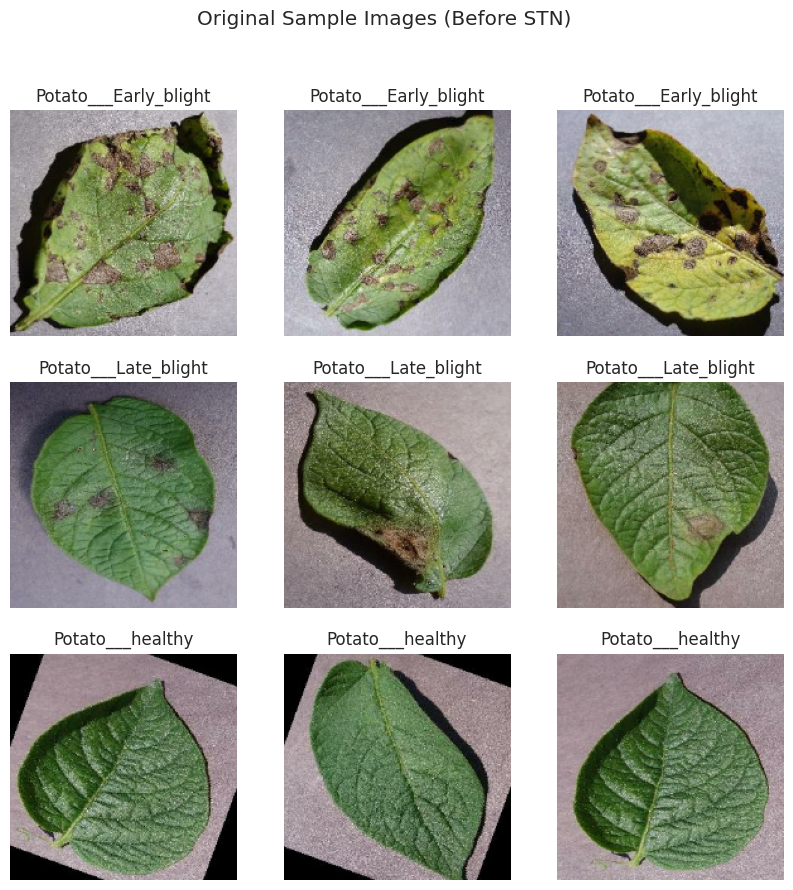

In [ ]:
# This section visualizes 3 random original images from each of the three potato classes.
print("\nVisualizing random original samples from each class...")

# Create a shuffled version of the training dataset for random sampling
shuffled_train_ds = train_ds.unbatch().shuffle(buffer_size=2000)

# Create a dictionary to hold the sample images and labels for each class
samples = {class_name: [] for class_name in class_names}
samples_needed = 3
sample_images_list = []
sample_labels_list = []

# Iterate through the shuffled dataset to find samples
for image, label in shuffled_train_ds:
    class_name = class_names[label]
    if len(samples[class_name]) < samples_needed:
        samples[class_name].append((image, label))
        sample_images_list.append(image)
        sample_labels_list.append(label)

    # Check if we have collected enough samples for all classes
    if all(len(s) == samples_needed for s in samples.values()):
        break

# Plot the collected original samples
plt.figure(figsize=(10, 10))
for i in range(len(sample_images_list)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images_list[i].numpy().astype("uint8"))
    plt.title(class_names[sample_labels_list[i]])
    plt.axis("off")
plt.suptitle("Original Sample Images (Before STN)")
plt.show()

### 4. Spatial Transformer Network (STN)

In [ ]:
# An STN is a learnable module that can be inserted into a CNN. It learns to perform
# spatial transformations (like scaling, cropping, rotation) on an input feature map
# to make the model more robust to these variations.

class SpatialTransformer(layers.Layer):
    def __init__(self, **kwargs):
        super(SpatialTransformer, self).__init__(**kwargs)
        # Localization network to predict transformation parameters
        self.localization_net = Sequential([
            layers.Conv2D(8, kernel_size=7, activation='relu'),
            layers.MaxPooling2D(pool_size=2, strides=2),
            layers.Conv2D(10, kernel_size=5, activation='relu'),
            layers.MaxPooling2D(pool_size=2, strides=2),
            layers.Flatten(),
            layers.Dense(32, activation='relu'),
            # Output 6 parameters for the affine transformation matrix
            layers.Dense(6, bias_initializer=tf.keras.initializers.Constant([1.0, 0.0, 0.0, 0.0, 1.0, 0.0]))
        ])

    def call(self, inputs):
        # Pass input through the localization network to get transformation matrix
        theta = self.localization_net(inputs)
        # Reshape to a 2x3 matrix
        theta = tf.reshape(theta, [-1, 2, 3])

        # Get the shape of the input
        input_shape = tf.shape(inputs)
        batch_size, height, width = input_shape[0], input_shape[1], input_shape[2]

        # Generate a grid of coordinates
        x = tf.linspace(-1.0, 1.0, width)
        y = tf.linspace(-1.0, 1.0, height)
        x_t, y_t = tf.meshgrid(x, y)

        # Flatten the grid
        x_t_flat = tf.reshape(x_t, [-1])
        y_t_flat = tf.reshape(y_t, [-1])
        ones = tf.ones_like(x_t_flat)
        sampling_grid = tf.stack([x_t_flat, y_t_flat, ones])
        sampling_grid = tf.expand_dims(sampling_grid, axis=0)
        sampling_grid = tf.tile(sampling_grid, tf.stack([batch_size, 1, 1]))

        # Transform the grid using the predicted theta
        batch_grid = tf.matmul(theta, sampling_grid)
        batch_grid = tf.reshape(batch_grid, [batch_size, 2, height, width])

        x_s = batch_grid[:, 0, :, :]
        y_s = batch_grid[:, 1, :, :]

        # Sample the input image using the transformed grid
        x = tf.cast((x_s + 1.0) * 0.5 * tf.cast(width, 'float32'), 'int32')
        y = tf.cast((y_s + 1.0) * 0.5 * tf.cast(height, 'float32'), 'int32')

        x = tf.clip_by_value(x, 0, width - 1)
        y = tf.clip_by_value(y, 0, height - 1)

        # Gather pixels
        batch_idx = tf.range(0, batch_size)
        batch_idx = tf.reshape(batch_idx, (batch_size, 1, 1))
        b = tf.tile(batch_idx, (1, height, width))
        indices = tf.stack([b, y, x], 3)

        return tf.gather_nd(inputs, indices)

### 5. Build the CNN Model with STN

In [ ]:
model = Sequential([
  # Rescale pixels to [0, 1]
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  # Add the Spatial Transformer Network to align the images
  SpatialTransformer(),

  # Convolutional blocks
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),

  # Flatten and Dense layers
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### 6. Compile and Train the Model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

# Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

epochs = 15
print("\nStarting model training...")
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
print("Model training finished.")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_transformer             │ (None, 180, 180, 3)    │       541,344 │
│ (SpatialTransformer)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,530,371 (17.28 MB)

 Trainable params: 4,530,371 (17.28 MB)

 Non-trainable params: 0 (0.00 B)


Starting model training...
Epoch 1/15
    179/Unknown 266s 1s/step - accuracy: 0.6519 - loss: 0.8446

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


179/179 ━━━━━━━━━━━━━━━━━━━━ 366s 2s/step - accuracy: 0.6520 - loss: 0.8443 - val_accuracy: 0.7496 - val_loss: 0.5896
Epoch 2/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 248s 1s/step - accuracy: 0.7407 - loss: 0.6210 - val_accuracy: 0.8191 - val_loss: 0.4952
Epoch 3/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8060 - loss: 0.5034

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


KeyboardInterrupt: 

### 7. Visualize Training Results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'history' is not defined

### 8. Visualize the Effect of the TRAINED STN


Visualizing the same samples after STN has been trained...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step


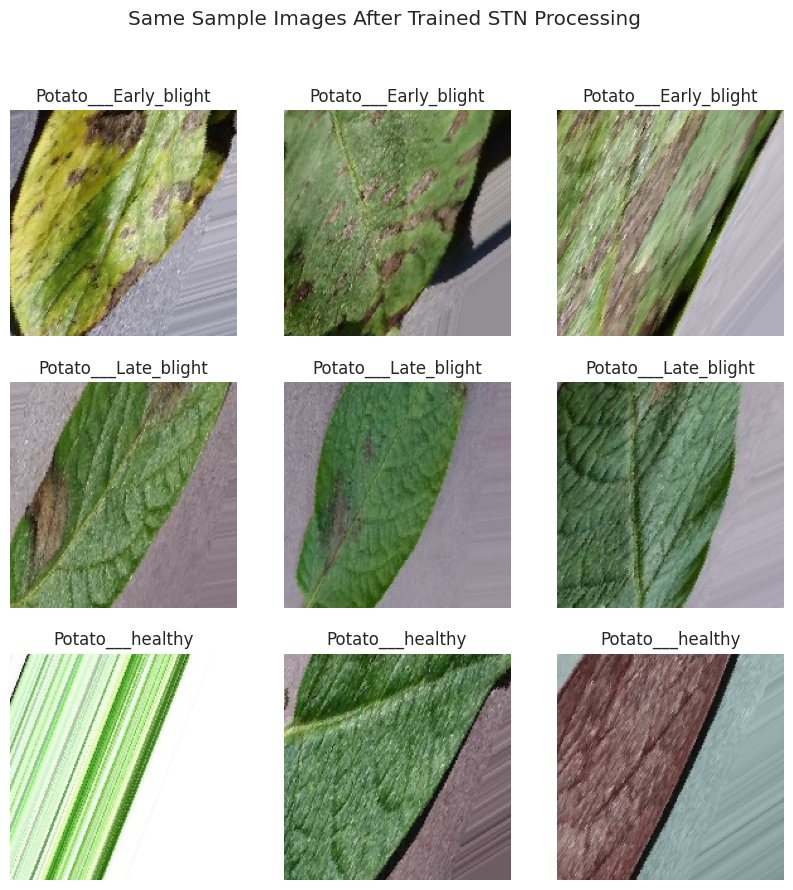

In [ ]:
# This section visualizes how the TRAINED STN processes the same images from Section 2.
print("\nVisualizing the same samples after STN has been trained...")

# Extract the trained Rescaling and SpatialTransformer layers from our main model.
# The model is: [Rescaling, SpatialTransformer, Conv2D, ...]
rescaling_layer = model.layers[0]
trained_stn_layer = model.layers[1]

# Create a new, temporary model with just the trained layers.
stn_visualization_model = Sequential([
    rescaling_layer,
    trained_stn_layer
])

# Stack the original sample images (collected in Section 2) into a single batch
sample_images_batch = tf.stack(sample_images_list)

# Get the transformed images by passing the batch through the trained STN model
transformed_images = stn_visualization_model.predict(sample_images_batch)

# Plot the transformed samples
plt.figure(figsize=(10, 10))
for i in range(len(transformed_images)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(transformed_images[i])
    plt.title(class_names[sample_labels_list[i]])
    plt.axis("off")
plt.suptitle("Same Sample Images After Trained STN Processing")
plt.show()

## 2. Analyse input data from user

### 1. Make a Prediction on a New leaf Image


--- Make a Prediction ---


Saving late-blight-on-foliage.jpg to late-blight-on-foliage (3).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


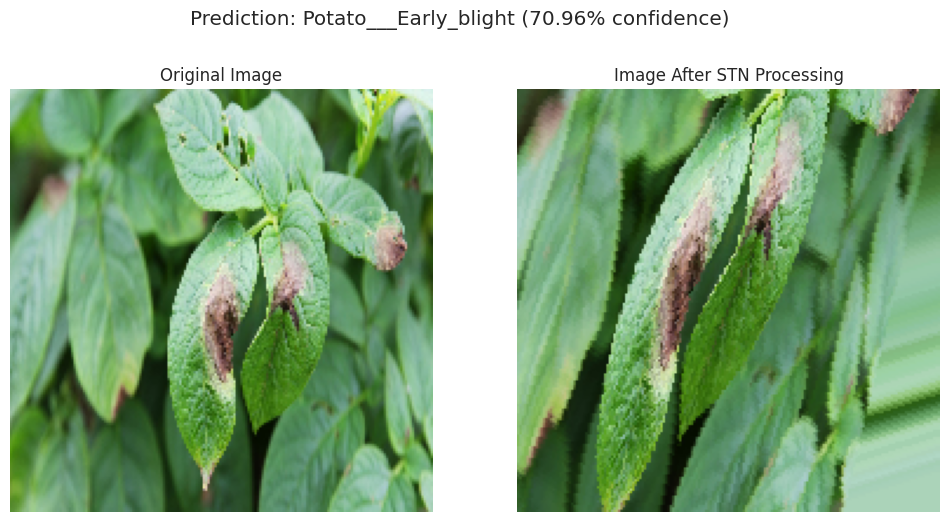

In [ ]:
print("\n--- Make a Prediction ---")

# Allow user to upload an image
uploaded_files = files.upload()

# Process the uploaded file
for file_path in uploaded_files.keys():
    # Load the image
    img = tf.keras.utils.load_img(
        file_path, target_size=(img_height, img_width)
    )

    # Convert the image to a numpy array for processing and prediction
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    # Make a prediction using the full model
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    predicted_class = class_names[np.argmax(score)]
    confidence = 100 * np.max(score)

    # Get the transformed image for visualization
    # We use the stn_visualization_model we created in the previous step
    transformed_img_array = stn_visualization_model.predict(img_array)

    # Display the results
    plt.figure(figsize=(12, 6))
    plt.suptitle(f"Prediction: {predicted_class} ({confidence:.2f}% confidence)")

    # Display original image
    ax = plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis("off")

    # Display transformed image
    ax = plt.subplot(1, 2, 2)
    # The output of the STN model is a batch, so we take the first (and only) image
    plt.imshow(transformed_img_array[0])
    plt.title("Image After STN Processing")
    plt.axis("off")

    plt.show()

### 2. Feedback Loop for leaf model training

In [ ]:
feedback = input(f"Was the prediction '{predicted_class}' correct? (yes/no): ").lower()

if feedback == 'no':
    print("Sorry to hear that. Let's correct it.")
    correct_label_str = ""
    while correct_label_str not in class_names:
        print("Please enter the correct class name from the following options:")
        print(class_names)
        correct_label_str = input("Correct label: ")

    # Define the path for saving feedback images
    feedback_dir = "feedback_images"
    correct_class_dir = os.path.join(feedback_dir, correct_label_str)

    # Create the directories if they don't exist
    os.makedirs(correct_class_dir, exist_ok=True)

    # Save the original uploaded image to the correct folder
    # We use the original file path from the upload
    destination_path = os.path.join(correct_class_dir, os.path.basename(file_path))
    shutil.copy(file_path, destination_path)

    print(f"\nThank you! The image has been saved to '{destination_path}'.")
    print("You can use the images in this folder to retrain and improve the model in the future.")

elif feedback == 'yes':
    print("\nGreat! Thank you for the confirmation.")
else:
    print("\nInvalid input. Skipping feedback.")

Was the prediction 'Potato___Early_blight' correct? (yes/no): no
Sorry to hear that. Let's correct it.
Please enter the correct class name from the following options:
['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
Correct label: Potato___Late_blight

Thank you! The image has been saved to 'feedback_images/Potato___Late_blight/late-blight-on-foliage (3).jpg'.
You can use the images in this folder to retrain and improve the model in the future.


## 3. Give feedback from inputs

In [ ]:
# --- Recommendations Section ---
print("\n--- Recommendations ---")
if predicted_class == 'Potato___Early_blight':
    print("Diagnosis: Early Blight")
    print("This is a common fungal disease (*Alternaria solani*). Here are some steps you can take:")
    print("- Pruning: Carefully remove and destroy the infected lower leaves to reduce the source of spores.")
    print("- Water Management: Water at the base of the plant in the morning to allow leaves to dry during the day. Avoid overhead watering.")
    print("- Improve Airflow: Ensure good spacing between plants to reduce humidity.")
    print("- Fungicides: For more severe cases, consider applying a fungicide containing mancozeb or chlorothalonil. Always follow label instructions.")
elif predicted_class == 'Potato___Late_blight':
    print("Diagnosis: Late Blight")
    print("This is a serious and aggressive disease (*Phytophthora infestans*). Act quickly:")
    print("- Immediate Removal: Remove and destroy infected plants immediately to prevent rapid spread. Bag them securely or burn them if possible.")
    print("- Check Tubers: When harvesting, carefully inspect tubers for brown, corky rot and do not store any suspect potatoes.")
    print("- Preventative Sprays: This disease is very difficult to control once established. Preventative fungicide applications are key, especially during cool, wet weather.")
    print("- Crop Rotation: Do not plant potatoes or tomatoes in the same spot for at least 3-4 years.")
elif predicted_class == 'Potato___healthy':
    print("Diagnosis: Healthy")
    print("Great news! The leaf appears to be healthy. To keep your plants this way:")
    print("- Monitor Regularly: Continue to inspect your plants weekly for any early signs of disease.")
    print("- Good Practices: Maintain good air circulation, proper watering (at the base), and balanced nutrition.")
    print("- Remove Weeds: Keep the area free of weeds, especially other plants in the nightshade family.")


--- Recommendations ---


NameError: name 'predicted_class' is not defined

# Soil Analysis

## 1. Import soil data


In [ ]:
path = kagglehub.dataset_download("atharvaingle/crop-recommendation-dataset")
print("Path to plants dataset files:", path)

100%|██████████| 63.7k/63.7k [00:00<00:00, 37.2MB/s]

Extracting files...
Path to plants dataset files: /root/.cache/kagglehub/datasets/atharvaingle/crop-recommendation-dataset/versions/1


In [ ]:
# --- Kaggle Dataset Setup ---
# This section handles the download of the dataset directly from Kaggle using the kagglehub library.
# You will need to authenticate with Kaggle. In Colab, this is done by uploading your kaggle.json file.

from google.colab import files
import kagglehub

# Authenticate with Kaggle
# We check if the API key already exists to avoid asking for it on every run.
if not os.path.exists('/root/.kaggle/kaggle.json'):
    print("Please upload your kaggle.json file to authenticate with Kaggle.")
    # This will open a file upload dialog.
    uploaded = files.upload()

    # Check if the file was uploaded
    if 'kaggle.json' in uploaded:
        print("kaggle.json uploaded successfully.")
        # Set up the Kaggle directory and permissions
        !mkdir -p ~/.kaggle
        !cp kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
    else:
        # Stop execution if the key is not provided, as the download will fail.
        raise Exception("kaggle.json was not uploaded. Please run this cell again to upload the file.")
else:
    print("Kaggle API key found. Skipping upload.")

# Download the latest version of the dataset using KaggleHub
print("\nDownloading dataset using KaggleHub...")
dataset_path = kagglehub.dataset_download("atharvaingle/crop-recommendation-dataset")
print("Dataset downloaded to:", dataset_path)

Please upload your kaggle.json file to authenticate with Kaggle.


Saving kaggle.json to kaggle.json
kaggle.json uploaded successfully.

Dataset downloaded to: /kaggle/input/crop-recommendation-dataset


Dataset Shape: (2200, 8)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB
None

First few rows:
    N   P   K  temperature   humidity        ph    rainfall label
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice
4  78  42  42    2

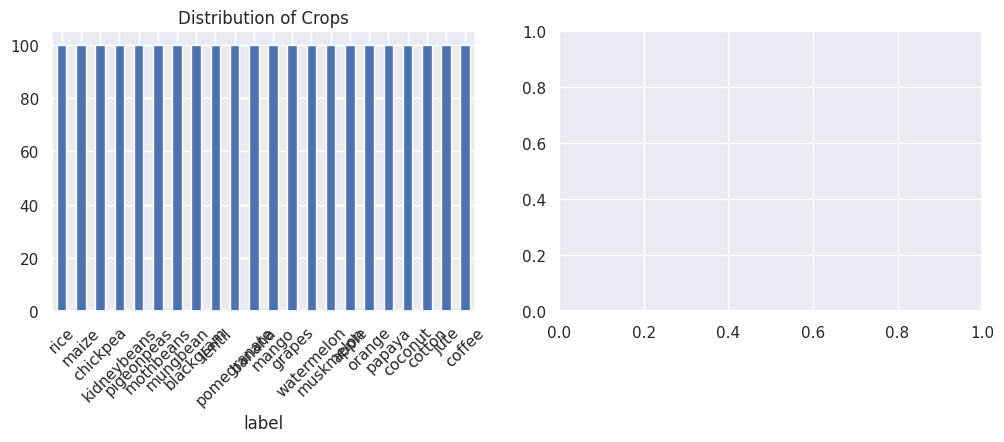

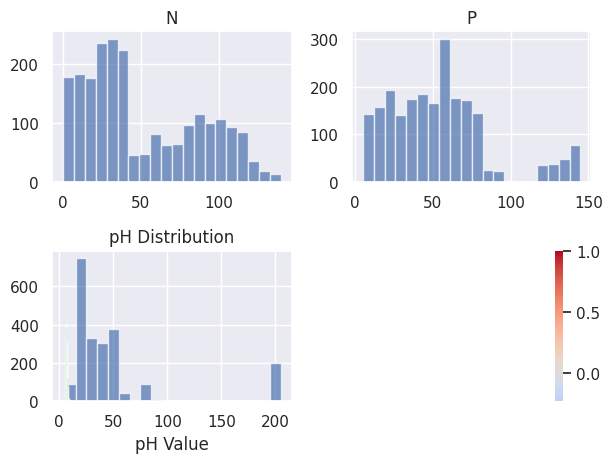

In [ ]:
df = pd.read_csv('Crop_recommendation.csv')

print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())

# Dataset columns:
# N - Nitrogen content in soil
# P - Phosphorous content in soil
# K - Potassium content in soil
# temperature - Temperature in Celsius
# humidity - Relative humidity in %
# ph - pH value of soil
# rainfall - Rainfall in mm
# label - Crop type

# EXPLORATORY DATA ANALYSIS

# Basic statistics
print("\nDataset Statistics:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())

# Distribution of crops
plt.figure(figsize=(12, 8))
crop_counts = df['label'].value_counts()
plt.subplot(2, 2, 1)
crop_counts.plot(kind='bar')
plt.title('Distribution of Crops')
plt.xticks(rotation=45)

# Soil nutrients distribution
plt.subplot(2, 2, 2)
df[['N', 'P', 'K']].hist(bins=20, alpha=0.7)
plt.title('Soil Nutrients Distribution')

# pH distribution
plt.subplot(2, 2, 3)
plt.hist(df['ph'], bins=20, alpha=0.7, color='green')
plt.title('pH Distribution')
plt.xlabel('pH Value')

# Correlation heatmap
plt.subplot(2, 2, 4)
corr_matrix = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')

plt.tight_layout()
plt.show()

## 2. Soil Health Classification- Clustering



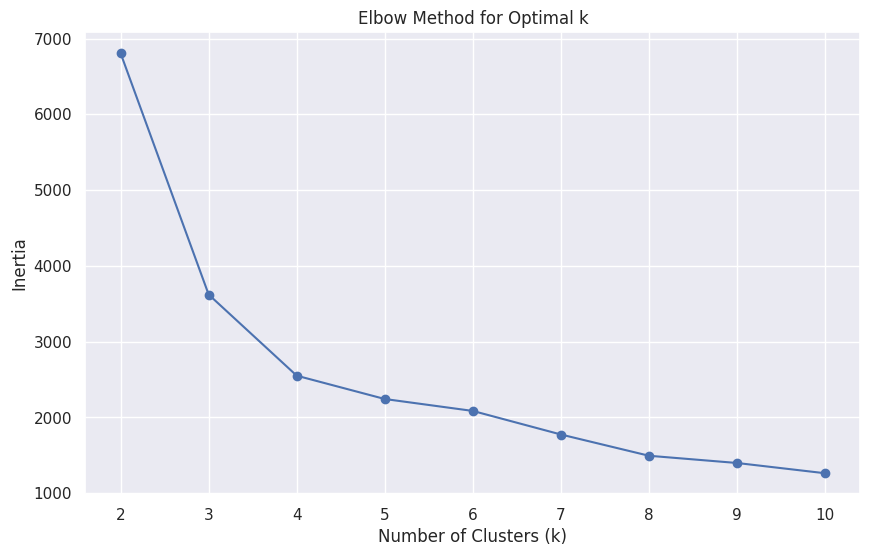


Cluster Analysis:
                             N           P           K        ph
soil_health_cluster                                             
0                    25.660219   47.481077   29.473507  6.533874
1                    94.088779   42.254007   38.081381  6.496326
2                    21.990000  133.375000  200.000000  5.977800

Soil Health Distribution:
soil_health
Poor      1189
Medium     811
Good       200
Name: count, dtype: int64


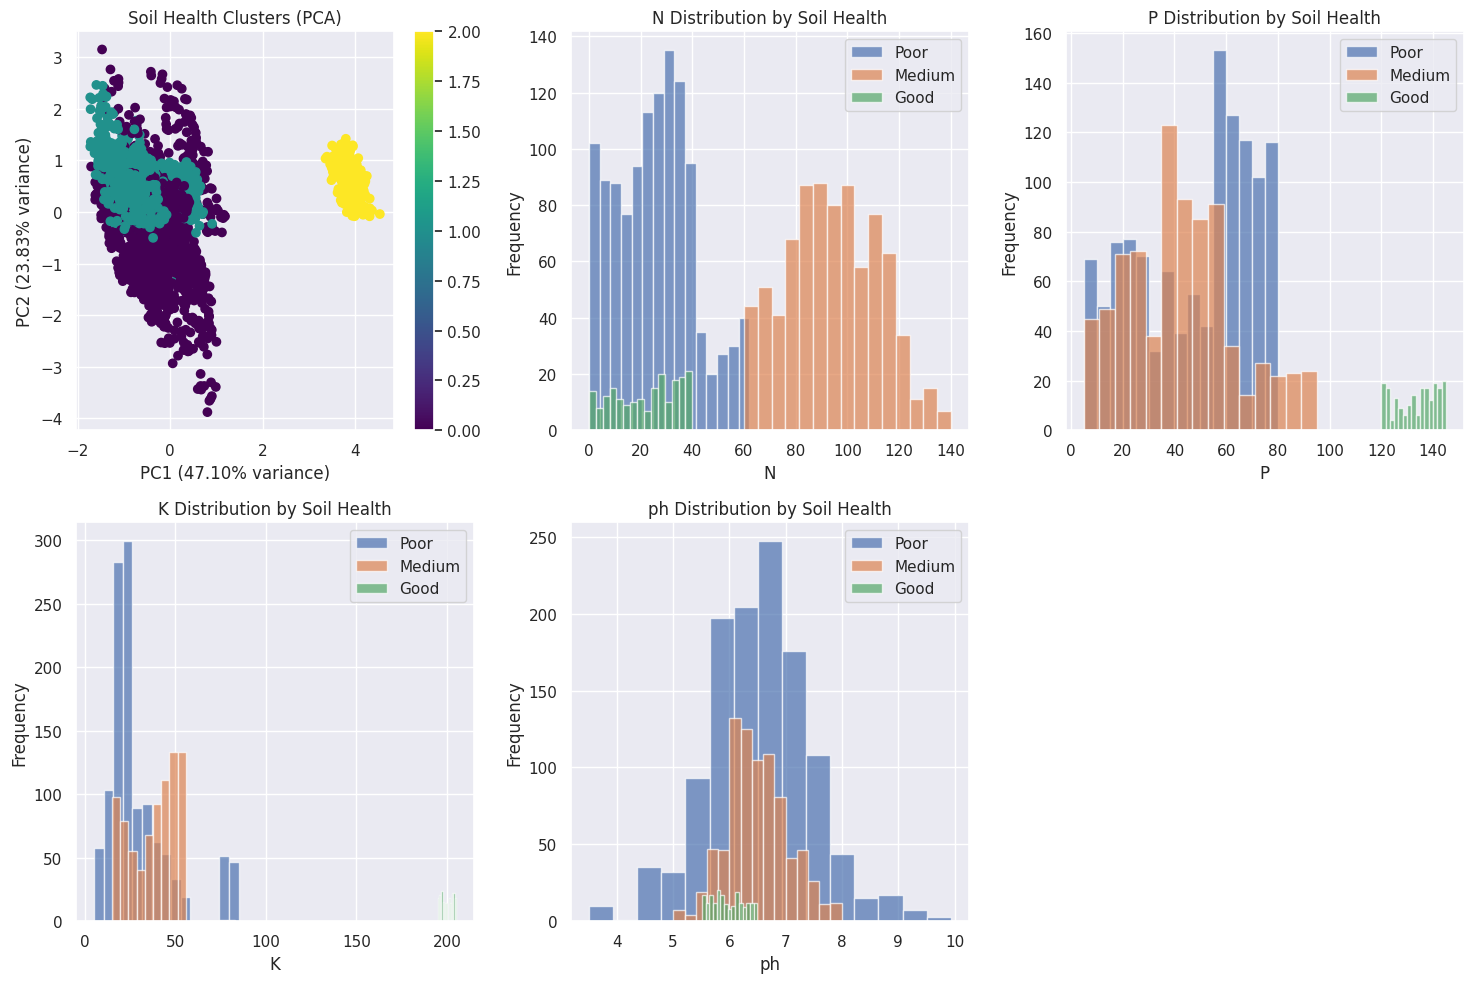

In [ ]:
# Select soil-related features for clustering
soil_features = ['N', 'P', 'K', 'ph']
X_soil = df[soil_features].copy()

# Standardize the features
scaler = StandardScaler()
X_soil_scaled = scaler.fit_transform(X_soil)

# Determine optimal number of clusters using elbow method
inertias = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_soil_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

# Apply K-means clustering (using k=3: Poor, Medium, Good soil health)
kmeans = KMeans(n_clusters=3, random_state=42)
soil_clusters = kmeans.fit_predict(X_soil_scaled)

# Add cluster labels to dataframe
df['soil_health_cluster'] = soil_clusters

# Analyze clusters
print("\nCluster Analysis:")
cluster_analysis = df.groupby('soil_health_cluster')[soil_features].mean()
print(cluster_analysis)

# Define soil health labels based on cluster characteristics
def classify_soil_health(cluster_means):
    """
    Classify soil health based on cluster means
    Higher NPK and optimal pH (6.0-7.5) indicate better soil health
    """
    health_labels = {}

    for cluster in cluster_means.index:
        npk_sum = cluster_means.loc[cluster, ['N', 'P', 'K']].sum()
        ph_value = cluster_means.loc[cluster, 'ph']

        # Score based on NPK sum and pH optimality
        ph_score = 1 - abs(ph_value - 6.75) / 6.75  # Optimal pH around 6.75
        total_score = npk_sum / 300 + ph_score  # Normalize NPK and add pH score

        health_labels[cluster] = total_score

    # Sort by score and assign labels
    sorted_clusters = sorted(health_labels.items(), key=lambda x: x[1])

    labels = {}
    labels[sorted_clusters[0][0]] = 'Poor'
    labels[sorted_clusters[1][0]] = 'Medium'
    labels[sorted_clusters[2][0]] = 'Good'

    return labels

# Get health labels
health_mapping = classify_soil_health(cluster_analysis)
df['soil_health'] = df['soil_health_cluster'].map(health_mapping)

print("\nSoil Health Distribution:")
print(df['soil_health'].value_counts())

# Visualize clusters
plt.figure(figsize=(15, 10))

# PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_soil_scaled)

plt.subplot(2, 3, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=soil_clusters, cmap='viridis')
plt.title('Soil Health Clusters (PCA)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter)

# Feature distributions by cluster
features_to_plot = ['N', 'P', 'K', 'ph']
for i, feature in enumerate(features_to_plot):
    plt.subplot(2, 3, i+2)
    for health in ['Poor', 'Medium', 'Good']:
        data = df[df['soil_health'] == health][feature]
        plt.hist(data, alpha=0.7, label=health, bins=15)
    plt.title(f'{feature} Distribution by Soil Health')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

## 3. Predictive Model for Soil Health




Model Performance:
Accuracy: 0.9909

Classification Report:
              precision    recall  f1-score   support

        Good       1.00      1.00      1.00        40
      Medium       0.98      0.99      0.99       162
        Poor       1.00      0.99      0.99       238

    accuracy                           0.99       440
   macro avg       0.99      0.99      0.99       440
weighted avg       0.99      0.99      0.99       440



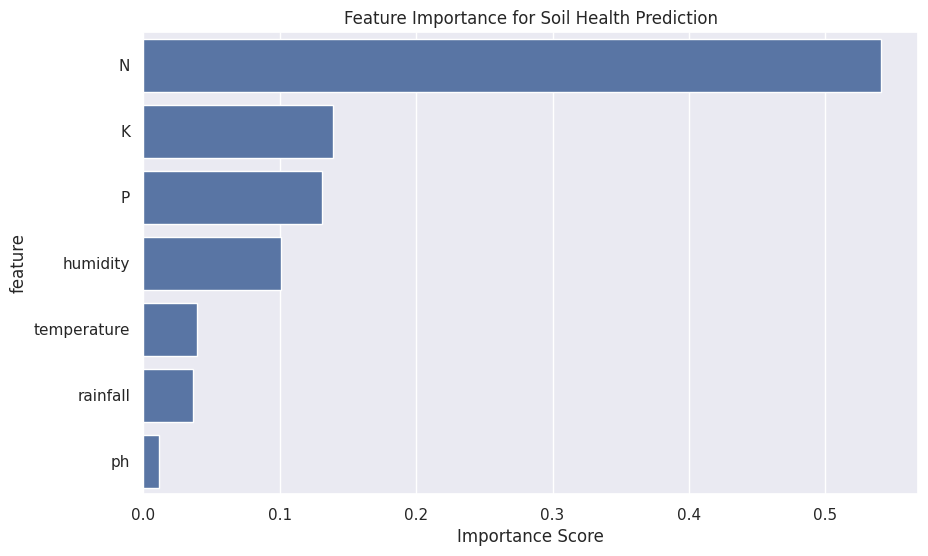


Feature Importance:
       feature  importance
0            N    0.541042
2            K    0.139420
1            P    0.131288
4     humidity    0.101025
3  temperature    0.039059
6     rainfall    0.036387
5           ph    0.011778


In [ ]:
# Prepare features for prediction
X = df[['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']]
y = df['soil_health']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler_model = StandardScaler()
X_train_scaled = scaler_model.fit_transform(X_train)
X_test_scaled = scaler_model.transform(X_test)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Evaluate model
print("\nModel Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance for Soil Health Prediction')
plt.xlabel('Importance Score')
plt.show()

print("\nFeature Importance:")
print(feature_importance)


In [ ]:
def predict_soil_health(N, P, K, temperature, humidity, ph, rainfall):
    """
    Predict soil health based on input parameters
    """
    # Create input array
    input_data = np.array([[N, P, K, temperature, humidity, ph, rainfall]])

    # Scale the input
    input_scaled = scaler_model.transform(input_data)

    # Make prediction
    prediction = rf_model.predict(input_scaled)[0]
    probability = rf_model.predict_proba(input_scaled)[0]

    # Get class probabilities
    classes = rf_model.classes_
    prob_dict = dict(zip(classes, probability))

    return prediction, prob_dict

## 4. Predictions



In [ ]:
def get_soil_recommendations(soil_health, N, P, K, ph):
    """
    Provide recommendations based on soil health classification
    """
    recommendations = []

    if soil_health == 'Poor':
        recommendations.append("IMMEDIATE ACTION NEEDED:")
        if N < 50:
            recommendations.append("- Add nitrogen-rich fertilizers (urea, ammonium sulfate)")
        if P < 30:
            recommendations.append("- Apply phosphorus fertilizers (superphosphate)")
        if K < 30:
            recommendations.append("- Use potassium fertilizers (potassium chloride)")
        if ph < 6.0:
            recommendations.append("- Apply lime to increase pH")
        elif ph > 7.5:
            recommendations.append("- Add sulfur or organic matter to lower pH")

    elif soil_health == 'Medium':
        recommendations.append("MODERATE IMPROVEMENT NEEDED:")
        recommendations.append("- Regular soil testing every 6 months")
        recommendations.append("- Balanced NPK fertilization")
        recommendations.append("- Add organic compost")

    else:  # Good
        recommendations.append("EXCELLENT SOIL HEALTH:")
        recommendations.append("- Maintain current practices")
        recommendations.append("- Monitor nutrient levels quarterly")
        recommendations.append("- Continue organic matter additions")

    return recommendations

def display_prediction_results(sample_name, sample_data):
    """
    Display prediction results in a formatted way for presentations
    """
    print(f"\n{'='*60}")
    print(f"SOIL ANALYSIS RESULTS - {sample_name.upper()}")
    print(f"{'='*60}")

    # Make prediction
    prediction, probabilities = predict_soil_health(**sample_data)

    # Display input parameters
    print(f"\nINPUT PARAMETERS:")
    print(f"   Nitrogen (N):     {sample_data['N']:>6.1f} kg/ha")
    print(f"   Phosphorus (P):   {sample_data['P']:>6.1f} kg/ha")
    print(f"   Potassium (K):    {sample_data['K']:>6.1f} kg/ha")
    print(f"   pH Level:         {sample_data['ph']:>6.1f}")
    print(f"   Temperature:      {sample_data['temperature']:>6.1f}°C")
    print(f"   Humidity:         {sample_data['humidity']:>6.1f}%")
    print(f"   Rainfall:         {sample_data['rainfall']:>6.1f} mm")

    # Display prediction
    print(f"\nPREDICTION RESULTS:")
    print(f"   Soil Health Status: {prediction}")

    # Display probabilities with visual bars
    print(f"\nCONFIDENCE LEVELS:")
    for health, prob in sorted(probabilities.items()):
        bar_length = int(prob * 30)  # Scale to 30 characters
        bar = "█" * bar_length + "░" * (30 - bar_length)
        print(f"   {health:>6}: {bar} {prob*100:5.1f}%")

    # Get and display recommendations
    recommendations = get_soil_recommendations(
        prediction,
        sample_data['N'],
        sample_data['P'],
        sample_data['K'],
        sample_data['ph']
    )

    print(f"\nRECOMMENDATIONS:")
    for rec in recommendations:
        print(f"   {rec}")

    print(f"\n{'='*60}")

    return prediction, probabilities

## 5. Recommendations



In [ ]:
def get_soil_recommendations(soil_health, N, P, K, ph):
    """
    Provide recommendations based on soil health classification
    """
    recommendations = []

    if soil_health == 'Poor':
        recommendations.append("IMMEDIATE ACTION NEEDED:")
        if N < 50:
            recommendations.append("- Add nitrogen-rich fertilizers (urea, ammonium sulfate)")
        if P < 30:
            recommendations.append("- Apply phosphorus fertilizers (superphosphate)")
        if K < 30:
            recommendations.append("- Use potassium fertilizers (potassium chloride)")
        if ph < 6.0:
            recommendations.append("- Apply lime to increase pH")
        elif ph > 7.5:
            recommendations.append("- Add sulfur or organic matter to lower pH")

    elif soil_health == 'Medium':
        recommendations.append("MODERATE IMPROVEMENT NEEDED:")
        recommendations.append("- Regular soil testing every 6 months")
        recommendations.append("- Balanced NPK fertilization")
        recommendations.append("- Add organic compost")

    else:  # Good
        recommendations.append("EXCELLENT SOIL HEALTH:")
        recommendations.append("- Maintain current practices")
        recommendations.append("- Monitor nutrient levels quarterly")
        recommendations.append("- Continue organic matter additions")

    return recommendations

def display_prediction_results(sample_name, sample_data):
    """
    Display prediction results in a formatted way for presentations
    """
    print(f"\n{'='*60}")
    print(f"SOIL ANALYSIS RESULTS - {sample_name.upper()}")
    print(f"{'='*60}")

    # Make prediction
    prediction, probabilities = predict_soil_health(**sample_data)

    # Display input parameters
    print(f"\nINPUT PARAMETERS:")
    print(f"   Nitrogen (N):     {sample_data['N']:>6.1f} kg/ha")
    print(f"   Phosphorus (P):   {sample_data['P']:>6.1f} kg/ha")
    print(f"   Potassium (K):    {sample_data['K']:>6.1f} kg/ha")
    print(f"   pH Level:         {sample_data['ph']:>6.1f}")
    print(f"   Temperature:      {sample_data['temperature']:>6.1f}°C")
    print(f"   Humidity:         {sample_data['humidity']:>6.1f}%")
    print(f"   Rainfall:         {sample_data['rainfall']:>6.1f} mm")

    # Display prediction
    print(f"\nPREDICTION RESULTS:")
    print(f"   Soil Health Status: {prediction}")

    # Display probabilities with visual bars
    print(f"\nCONFIDENCE LEVELS:")
    for health, prob in sorted(probabilities.items()):
        bar_length = int(prob * 30)  # Scale to 30 characters
        bar = "█" * bar_length + "░" * (30 - bar_length)
        print(f"   {health:>6}: {bar} {prob*100:5.1f}%")

    # Get and display recommendations
    recommendations = get_soil_recommendations(
        prediction,
        sample_data['N'],
        sample_data['P'],
        sample_data['K'],
        sample_data['ph']
    )

    print(f"\n💡 RECOMMENDATIONS:")
    for rec in recommendations:
        print(f"   {rec}")

    print(f"\n{'='*60}")

    return prediction, probabilities

## 6. Test Section



In [ ]:
print("\n" + "="*70)
print("INTERACTIVE SOIL HEALTH TESTING SYSTEM")
print("="*70)

# Pre-defined test cases for different scenarios
test_cases = {
    "Healthy Farm A": {
        'N': 85, 'P': 65, 'K': 50,
        'temperature': 22.5, 'humidity': 75.0,
        'ph': 6.8, 'rainfall': 180.5
    },
    "Poor Soil Sample": {
        'N': 25, 'P': 15, 'K': 20,
        'temperature': 28.0, 'humidity': 45.0,
        'ph': 5.2, 'rainfall': 50.0
    },
    "Medium Quality Field": {
        'N': 55, 'P': 35, 'K': 40,
        'temperature': 24.0, 'humidity': 68.0,
        'ph': 6.2, 'rainfall': 120.0
    },
    "Excellent Organic Farm": {
        'N': 120, 'P': 80, 'K': 75,
        'temperature': 21.0, 'humidity': 82.0,
        'ph': 7.0, 'rainfall': 220.0
    },
    "Desert Soil": {
        'N': 10, 'P': 8, 'K': 15,
        'temperature': 35.0, 'humidity': 20.0,
        'ph': 8.5, 'rainfall': 25.0
    }
}

# Run all test cases
for test_name, test_data in test_cases.items():
    display_prediction_results(test_name, test_data)

def get_custom_input():
    """
    Function to get custom input from user
    """
    print("\n" + "="*70)
    print("CUSTOM SOIL TESTING")
    print("="*70)
    print("Enter your soil parameters below:")

    try:
        custom_data = {}
        custom_data['N'] = float(input("Nitrogen (N) content (kg/ha): "))
        custom_data['P'] = float(input("Phosphorus (P) content (kg/ha): "))
        custom_data['K'] = float(input("Potassium (K) content (kg/ha): "))
        custom_data['ph'] = float(input("pH level (0-14): "))
        custom_data['temperature'] = float(input("Temperature (°C): "))
        custom_data['humidity'] = float(input("Humidity (%): "))
        custom_data['rainfall'] = float(input("Rainfall (mm): "))

        return custom_data
    except ValueError:
        print("❌ Invalid input! Please enter numeric values.")
        return None


custom_input = get_custom_input()
if custom_input:
   display_prediction_results("Custom Input", custom_input)

print("\n" + "="*70)


print("\n" + "="*50)
print("ANALYSIS COMPLETE!")
print("="*50)


INTERACTIVE SOIL HEALTH TESTING SYSTEM

SOIL ANALYSIS RESULTS - HEALTHY FARM A

INPUT PARAMETERS:
   Nitrogen (N):       85.0 kg/ha
   Phosphorus (P):     65.0 kg/ha
   Potassium (K):      50.0 kg/ha
   pH Level:            6.8
   Temperature:        22.5°C
   Humidity:           75.0%
   Rainfall:          180.5 mm

PREDICTION RESULTS:
   Soil Health Status: Medium

CONFIDENCE LEVELS:
     Good: ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   0.0%
   Medium: ██████████████████████████████ 100.0%
     Poor: ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   0.0%

RECOMMENDATIONS:
   MODERATE IMPROVEMENT NEEDED:
   - Regular soil testing every 6 months
   - Balanced NPK fertilization
   - Add organic compost


SOIL ANALYSIS RESULTS - POOR SOIL SAMPLE

INPUT PARAMETERS:
   Nitrogen (N):       25.0 kg/ha
   Phosphorus (P):     15.0 kg/ha
   Potassium (K):      20.0 kg/ha
   pH Level:            5.2
   Temperature:        28.0°C
   Humidity:           45.0%
   Rainfall:           50.0 mm

PREDICTION RESULTS:
   Soil Heal